In [117]:
import ot
import ot.plot
import numpy as np
import matplotlib.pyplot as plt

import sys
DATA_PATH = '/home/risitop/OneDrive/Documents/PHD/y1/data/'
sys.path.append(DATA_PATH)

plt.style.use('dark_background')

In [118]:
def load_scores(fname, comps):
    X = []
    with open(fname, 'r') as f:
        for line in f:
            line = line[:-1].split(',')
            if line[0] in comps:
                X.append(list(map(float, line[1:])))
    return np.array(X).T

In [119]:
files = ['184', '352', '471', '856', '857', '861', '1057', '1058', 'CHLA9', 'CHLA10', 'D085T8', 'TC71', 'Y79']
Xs = {}
for f in files:
    Xs[f] = load_scores(DATA_PATH + 'scores/%s.csv' % f, ['IC1+', 'IC2+'])
    print(f, Xs[f].shape)
    
banlist = ['184', 'Y79', '857', '1057']

184 (187, 2)
352 (1937, 2)
471 (483, 2)
856 (398, 2)
857 (149, 2)
861 (906, 2)
1057 (128, 2)
1058 (478, 2)
CHLA9 (3752, 2)
CHLA10 (3407, 2)
D085T8 (183, 2)
TC71 (1478, 2)
Y79 (2874, 2)


In [120]:
x_label = '471'
xs = Xs[x_label]
yt = Xs['CHLA10']

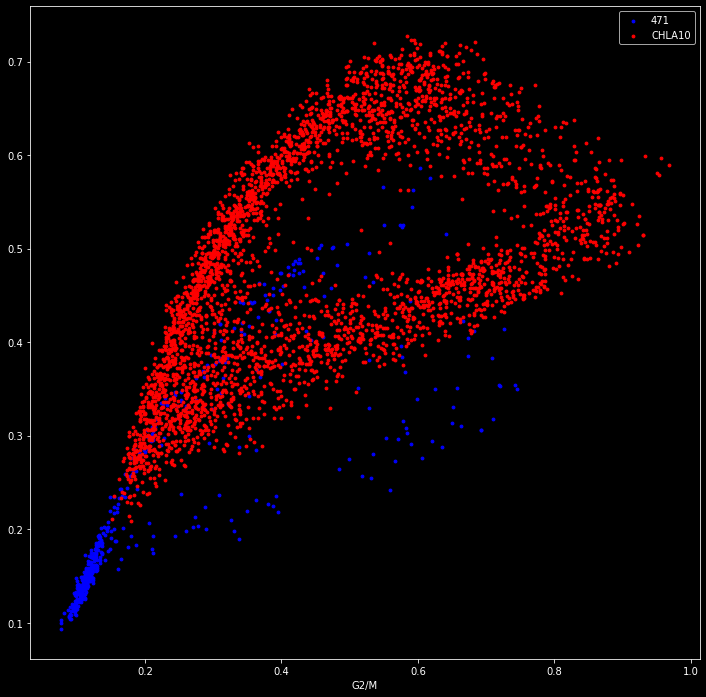

In [121]:
plt.figure(figsize=(12,12))

plt.scatter(xs[:,0], xs[:,1], s=8, c='blue', label=x_label)
plt.scatter(yt[:,0], yt[:,1], s=8, c='red', label='CHLA10')
plt.xlabel('G1/S')
plt.xlabel('G2/M')
plt.legend()

plt.savefig("before_OT.png")
pass

In [122]:
w_x, w_y = np.ones((len(xs),))/len(xs), np.ones((len(yt),))/len(yt)
M = ot.dist(xs, yt)
M /= M.max()

Gs = ot.sinkhorn(w_x, w_y, M, 1e-3)
xt_nodens = np.dot(Gs, yt)*len(xs)

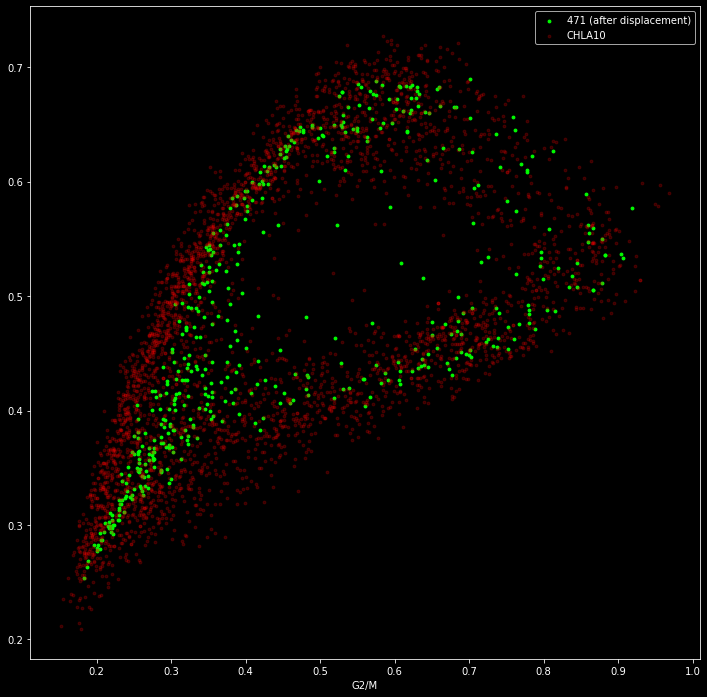

In [123]:
plt.figure(figsize=(12,12))

plt.scatter(xt_nodens[:,0], xt_nodens[:,1], s=8, c='lime', label=x_label + ' (after displacement)')
plt.scatter(yt[:,0], yt[:,1], s=8, alpha=0.2, c='red', label='CHLA10')
plt.xlabel('G1/S')
plt.xlabel('G2/M')
plt.legend()

plt.savefig("after_OT.png")
pass

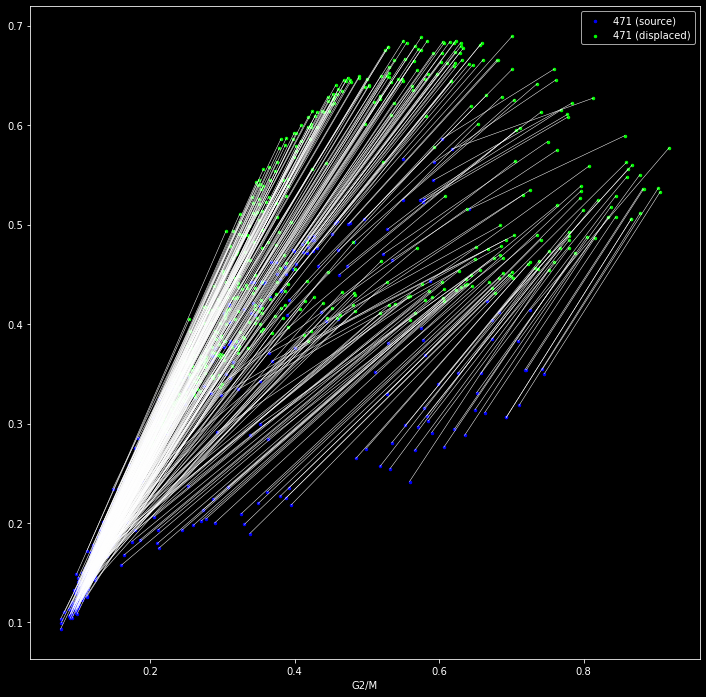

In [124]:
plt.figure(figsize=(12,12))
for ((x1, y1), (x2, y2)) in zip(xs, xt_nodens):
    plt.plot([x1, x2], [y1, y2], c='w', linewidth=0.5)
plt.scatter(xs[:,0], xs[:,1], s=6, c='blue', label=x_label + ' (source)')
plt.scatter(xt_nodens[:,0], xt_nodens[:,1], s=6, c='lime', label=x_label + ' (displaced)')
plt.xlabel('G1/S')
plt.xlabel('G2/M')
plt.legend()

plt.savefig("OT_displacement.png")

# Local density computation

In [125]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

def compute_discrepancy_nn(Xs, Xt, n_neighbors=3):
    nns = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(Xs).kneighbors_graph(Xs).toarray()
    nnt = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(Xt).kneighbors_graph(Xt).toarray()
    D = nnt - nns
    return np.linalg.norm(D, axis=0).astype(float)/n_neighbors

def compute_discrepancy_d(Xs, Xt):
    ds = cdist(Xs, Xs)
    dt = cdist(Xt, Xt)
    D = nnt - nns
    return np.linalg.norm(D, axis=0).astype(float)/n_neighbors
    
def OT_raw(Xs, Yt, alph=1, bet=1):
    w_x, w_y = np.ones((len(Xs),))/len(Xs), np.ones((len(Yt),))/len(Yt)
    M = ot.dist(Xs, Yt)**alph
    M /= M.max()
    Gs = ot.sinkhorn(w_x, w_y, M, 1e-3)
    return np.dot(np.diag(1/w_x), np.dot(Gs, Yt))

def OT_regularized(Xs, Yt, alph=1, bet=1, n_neighbors=3):
    Xt = OT_raw(Xs, Yt, alph, bet)
    lambdas = 1 - compute_discrepancy(Xs, Xt, n_neighbors)
    return np.dot(np.diag(lambdas), Xt - Xs) + Xs

def OT_oob(Xs, Yt, alph=1, bet=1, n_neighbors=3):
    n = len(Xs)
    Xt = OT_raw(Xs, Yt, alph, bet)
    lambdas = compute_discrepancy(Xs, Xt, n_neighbors)
    return np.hstack((Xt, np.reshape(lambdas, (n, 1))))

In [130]:
xt = OT_raw(xs, yt)
xtr = OT_regularized(xs, yt, n_neighbors=10)
xoob = OT_oob(xs, yt, n_neighbors=10)

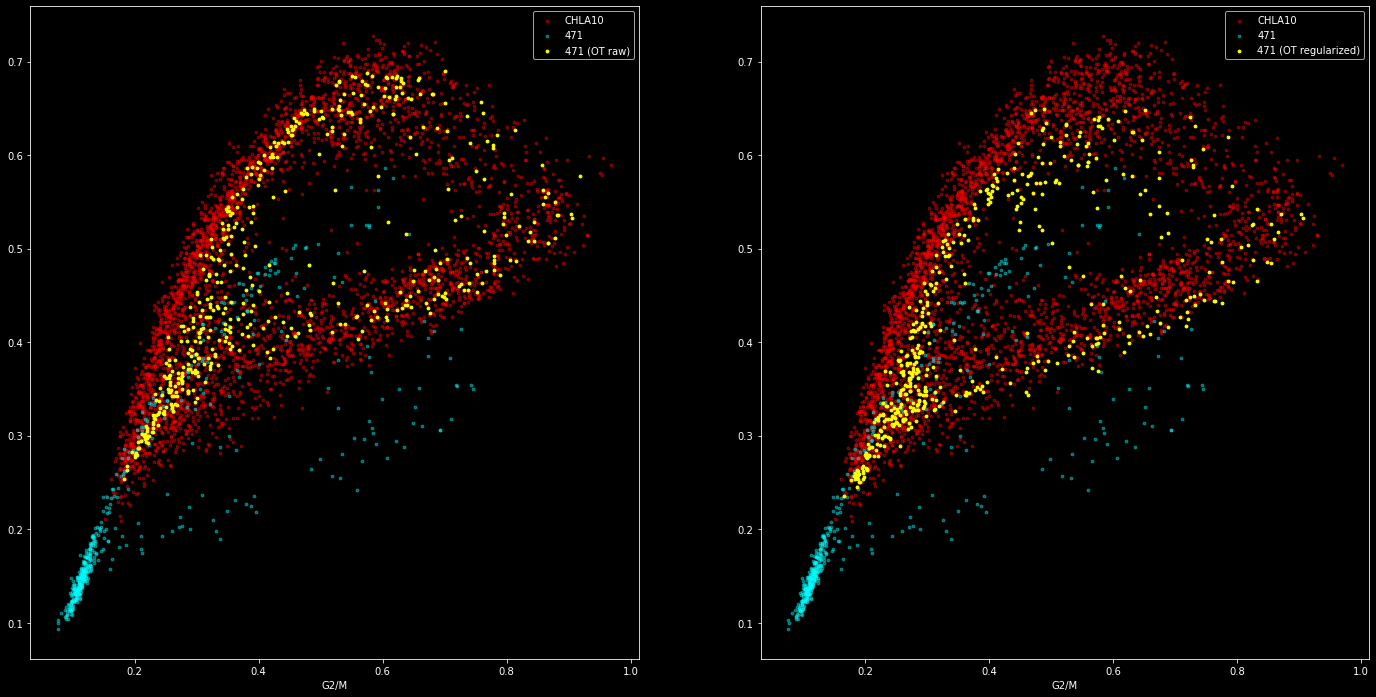

In [131]:
plt.figure(figsize=(24,12))

plt.subplot(1,2,1)
plt.scatter(yt[:,0], yt[:,1], s=8, alpha=0.4, c='red', label='CHLA10')
plt.scatter(xs[:,0], xs[:,1], s=8, alpha=0.4, c='cyan', label=x_label)
plt.scatter(xt[:,0], xt[:,1], s=8, c='yellow', label=x_label+' (OT raw)')
plt.xlabel('G1/S')
plt.xlabel('G2/M')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(yt[:,0], yt[:,1], s=8, alpha=0.4, c='red', label='CHLA10')
plt.scatter(xs[:,0], xs[:,1], s=8, alpha=0.4, c='cyan', label=x_label)
plt.scatter(xtr[:,0], xtr[:,1], s=8, c='yellow', label=x_label+' (OT regularized)')
plt.xlabel('G1/S')
plt.xlabel('G2/M')
plt.legend()

plt.savefig("after_OT.png")
pass

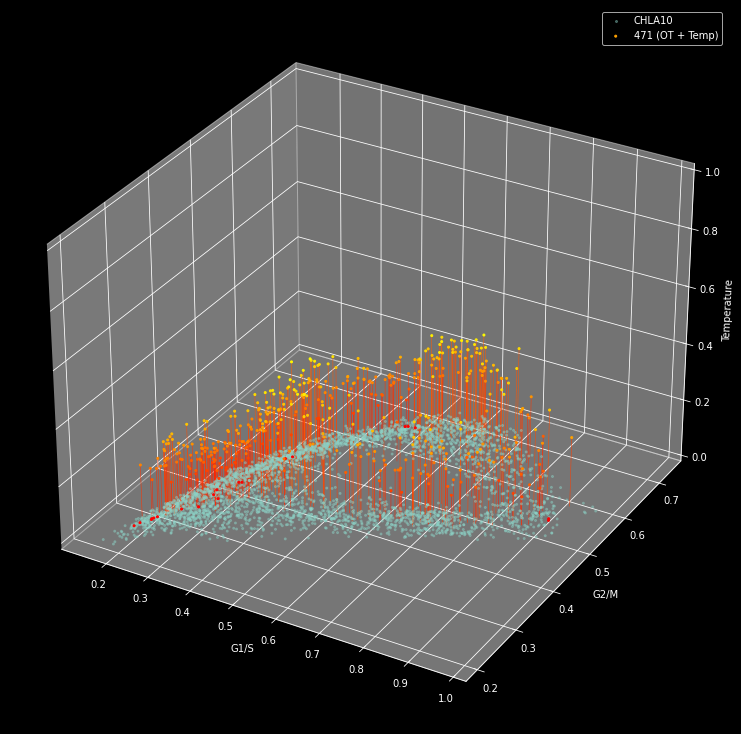

In [132]:
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.decomposition import PCA
from matplotlib import animation, rc
from IPython.display import HTML

from matplotlib import cm

my_cmap = cm.autumn

def update_clouds(angle, ax, clouds):
    ax.view_init(30, angle)
    ax.legend()
    ax.set_xlabel('G1/S')
    ax.set_ylabel('G2/M')
    ax.set_zlabel('Temperature')
    return clouds

fig = plt.figure(figsize=(10,10))
ax = p3.Axes3D(fig)
elements = [
    ax.scatter(yt[:,0], yt[:,1], [-.01 for _ in range(len(yt))], s=4, alpha=.4, label='CHLA10'),
    ax.scatter(xoob[:,0], xoob[:,1], xoob[:,2], s=4, alpha=1, c=xoob[:,2], cmap=my_cmap, label=x_label+' (OT + Temp)')
]
for ((x1, y1), (x2, y2, z2)) in zip(xt, xoob):
    elements.append(ax.plot([x1, x2], [y1, y2], [0, z2], c=my_cmap(z2), linewidth=0.5))

clouds_ani = animation.FuncAnimation(fig, update_clouds, 360, fargs=(ax, clouds_std),
                                   interval=50, blit=False)
ax.legend()
ax.set_xlabel('G1/S')
ax.set_ylabel('G2/M')
ax.set_zlabel('Temperature')
ax.set_zlim(0, 1)
plt.show()

In [133]:
HTML(clouds_ani.to_html5_video())